In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb
import re

from sklearn.cluster import KMeans
import seaborn as sns

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
warnings.filterwarnings("ignore")

In [2]:
def pourcentage_erreur(x,y): ## On l'utilisera dans la question 4
    
    print("Le pourcentage d'erreur absolu médian est de {} %".format(np.round(np.median(np.abs(x.values.flatten() - y.values.flatten())/x.values.flatten())*100,2)))

In [3]:
df_sncf = pd.read_csv('validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem.csv',sep=';')## Import des données

In [4]:
df_sncf.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2019-01-08,810,802,744,AEROPORT CHARLES DE GAULLE 2-TGV,73699.0,IMAGINE R,532
1,2019-05-01,100,110,547,MIRABEAU,71162.0,IMAGINE R,273
2,2019-01-08,810,802,77,BLANC-MESNIL,72648.0,FGT,308
3,2019-05-01,100,110,547,MIRABEAU,71162.0,NAVIGO,992
4,2019-01-08,810,802,77,BLANC-MESNIL,72648.0,NAVIGO JOUR,Moins de 5


## Question 1 : Les 20 premières stations en terme de validation.
---

In [5]:
df_sncf.LIBELLE_ARRET.value_counts()

GARE DE LYON                4545
LA DEFENSE-GRANDE ARCHE     4464
CHARLES DE GAULLE ETOILE    3156
DENFERT-ROCHEREAU           3081
MONTPARNASSE                3033
                            ... 
LA REMISE A JORELLE          468
THIEUX-NANTOUILLET           443
VOSVES                       438
GUILLERVAL                   418
MONNERVILLE                  340
Name: LIBELLE_ARRET, Length: 732, dtype: int64

> On a 732 différents arrêts.

In [6]:
df_sncf['NB_VALD']=df_sncf['NB_VALD'].apply(lambda x:int(re.search('\d+',x).group()))## On récupère le nombre de valdations 

In [7]:
df_sncf.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2019-01-08,810,802,744,AEROPORT CHARLES DE GAULLE 2-TGV,73699.0,IMAGINE R,532
1,2019-05-01,100,110,547,MIRABEAU,71162.0,IMAGINE R,273
2,2019-01-08,810,802,77,BLANC-MESNIL,72648.0,FGT,308
3,2019-05-01,100,110,547,MIRABEAU,71162.0,NAVIGO,992
4,2019-01-08,810,802,77,BLANC-MESNIL,72648.0,NAVIGO JOUR,5


In [8]:
## On regroupe les nombres de validation par rapport au libellet de l'arret.

arret_val_count = df_sncf[['LIBELLE_ARRET','NB_VALD']].groupby(["LIBELLE_ARRET"]).sum().sort_values(by='NB_VALD',ascending=False)
arret_val_count[:20]

,NB_VALD
LIBELLE_ARRET,
LA DEFENSE-GRANDE ARCHE,31142637
GARE DU NORD,28680591
GARE DE LYON,27034943
CHATELET-LES HALLES,22227056
SAINT-LAZARE,17781007
MONTPARNASSE,15635994
NATION,13806318
GARE DE L'EST,13518825
CHARLES DE GAULLE ETOILE,10731021


## Question 2 :Illustration graphique du classement.
---

<BarContainer object of 20 artists>

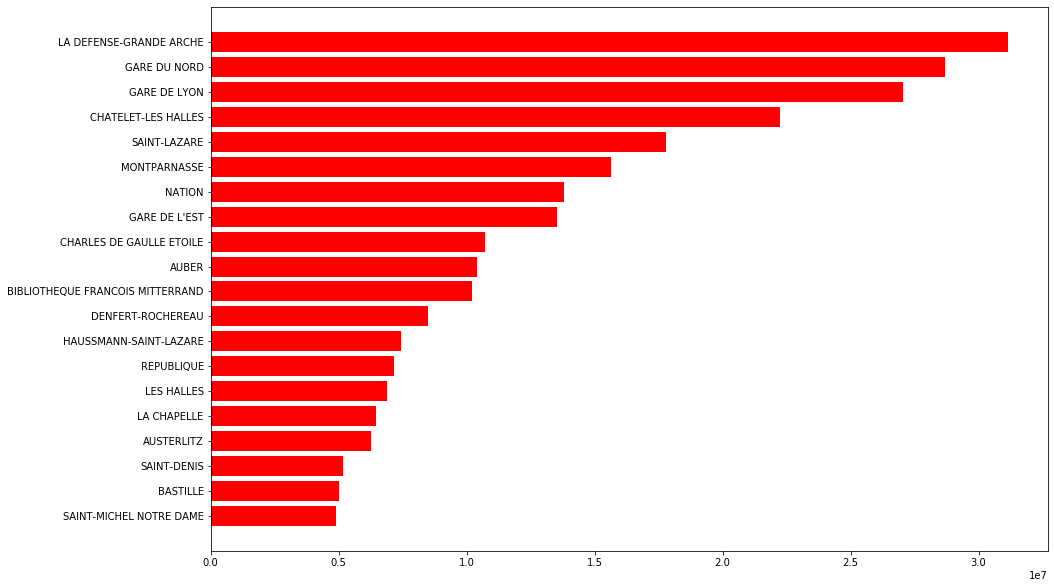

In [9]:
plt.figure(figsize=(15,10))
plt.barh(arret_val_count[:20][::-1].index , arret_val_count[:20][::-1].values.flatten(),color='r')

## Question 3 :Classification des arrets en se basant sur le nombre de validations par titre 
---

In [10]:
df_sncf.CATEGORIE_TITRE.value_counts()

NAVIGO         135127
IMAGINE R      134338
FGT            130955
TST            130781
AMETHYSTE      128760
?              120352
NAVIGO JOUR     92845
AUTRE TITRE     47909
NON DEFINI      19482
Name: CATEGORIE_TITRE, dtype: int64

In [11]:
## On regroupe les arrets par nombre de validation et par titre.

ARRET_par_TITRE=df_sncf[['CATEGORIE_TITRE','LIBELLE_ARRET','NB_VALD']].groupby(["CATEGORIE_TITRE" ,"LIBELLE_ARRET"]).sum().sort_values(by='NB_VALD',ascending=False)
ARRET_par_TITRE

NB_VALD
CATEGORIE_TITRE LIBELLE_ARRET                    
NAVIGO          LA DEFENSE-GRANDE ARCHE  24635570
                GARE DE LYON             20066879
                GARE DU NORD             19832037
                CHATELET-LES HALLES      15037760
                SAINT-LAZARE             13571395
...                                           ...
AUTRE TITRE     BOISSY-L'AILLERIE               5
                EPINAY VIL T11                  5
NON DEFINI      ROBINSON                        5
                SCEAUX                          5
AUTRE TITRE     LUZARCHES                       5

[6152 rows x 1 columns]

In [12]:
#Création de notre ensemble d'entrainement

X = pd.DataFrame(zip(list(ARRET_par_TITRE.index.get_level_values('CATEGORIE_TITRE')),list(ARRET_par_TITRE.NB_VALD)),index=ARRET_par_TITRE.index.get_level_values('LIBELLE_ARRET'),columns=['TITRE','NOMBRE_VAL'])
X

,TITRE,NOMBRE_VAL
LIBELLE_ARRET,,
LA DEFENSE-GRANDE ARCHE,NAVIGO,24635570
GARE DE LYON,NAVIGO,20066879
GARE DU NORD,NAVIGO,19832037
CHATELET-LES HALLES,NAVIGO,15037760
SAINT-LAZARE,NAVIGO,13571395
...,...,...
BOISSY-L'AILLERIE,AUTRE TITRE,5
EPINAY VIL T11,AUTRE TITRE,5
ROBINSON,NON DEFINI,5


In [13]:
## On transforme la variable titre en varible catégorielle avec des nombres.
cats ,codes =pd.factorize(X.TITRE)
X.TITRE = cats
X

,TITRE,NOMBRE_VAL
LIBELLE_ARRET,,
LA DEFENSE-GRANDE ARCHE,0,24635570
GARE DE LYON,0,20066879
GARE DU NORD,0,19832037
CHATELET-LES HALLES,0,15037760
SAINT-LAZARE,0,13571395
...,...,...
BOISSY-L'AILLERIE,7,5
EPINAY VIL T11,7,5
ROBINSON,8,5


In [14]:
X.TITRE.value_counts() ##Nombre d'observations pour chaque titre

3    732
2    732
5    732
1    732
4    732
0    732
6    730
7    682
8    348
Name: TITRE, dtype: int64

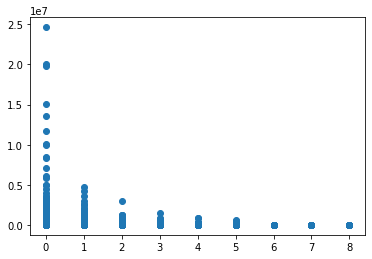

In [15]:
plt.scatter(X.TITRE,X.NOMBRE_VAL) ## Nombre de validation par titre pour chaque arret .

In [16]:
# on applqiue le k-means pour différents k pour choisir le nombre idéal de clusters.

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_ 

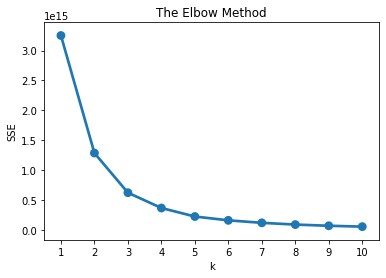

In [17]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

> On choisira finalement 3 clusters. A partir de 3 la courbe commence à devenir à peu près constante.

In [18]:
kmeans = KMeans(n_clusters=3, random_state=30).fit(X)


In [19]:
Resultat = pd.DataFrame(zip(list(X.index),codes[cats],X.NOMBRE_VAL,kmeans.labels_),columns=['LIBELLE_ARRET', 'TITRE','NB_VAL','CLUSTER'])

In [20]:
Resultat.CLUSTER.value_counts()

0    5855
2     287
1      10
Name: CLUSTER, dtype: int64

## Visualisation des résultats 

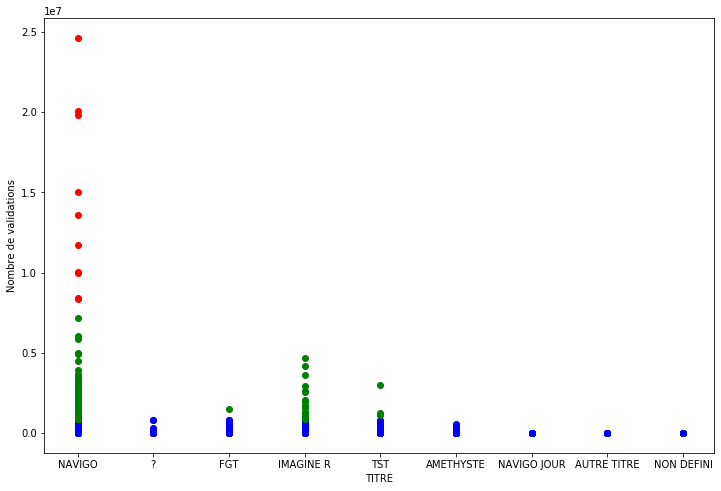

In [21]:
plt.figure(figsize=(12,8))
plt.scatter(Resultat[Resultat.CLUSTER ==0].TITRE,Resultat[Resultat.CLUSTER ==0].NB_VAL.values.flatten(),color ='blue')
plt.scatter(Resultat[Resultat.CLUSTER ==1].TITRE,Resultat[Resultat.CLUSTER ==1].NB_VAL.values.flatten(),color ='red')
plt.scatter(Resultat[Resultat.CLUSTER ==2].TITRE,Resultat[Resultat.CLUSTER ==2].NB_VAL.values.flatten(),color ='green')
plt.xlabel('TITRE')
plt.ylabel('Nombre de validations')
plt.show()

## Intérprétation : 
> Pour un titre donné, chaque point représentra le nombre de validations pour un arrêt différent. On a divisé notre ensemble de données en 3 clusters différents selon le nombre de validations par titre. On remarque que les points en rouges représentent les arrêts avec le plus grand nombre de validations, ces arrêts sont présents aussi dans le graphique de la question 2. Les points en vert sont associciés aux arrêts avec un nombre de validation moyen et ceux qui sont en bleux sont associés aux arrêts avec un petit nombre de validations.  


## Question 4 : Prédiction du nombre de validations pour les arrêts 'OLYMPIADES' et 'M. MONTROUGES' sur la plage du 24 au 30 Juin 2019.
---

In [22]:
df_sncf.JOUR = pd.to_datetime(df_sncf.JOUR)

In [23]:
Jour_LIBELLE = df_sncf[['JOUR','LIBELLE_ARRET','NB_VALD']].groupby(["JOUR",'LIBELLE_ARRET']).sum().sort_values(by='NB_VALD',ascending=False).sort_index()

In [24]:
"""
On dispose des valeurs qu'on cherche à prédire (24 jusqu'au 30 juin) donc on va les séparer de notre jeu de données.

On créera ensuite les jeux d'entrainement et de test pour entrainer et tester le modèle pour les 2 séries OLYMPIADES
etM. MONTROUGES.

"""

NB_VAl_OLYMPIADES=Jour_LIBELLE.iloc[Jour_LIBELLE.index.get_level_values('LIBELLE_ARRET') == 'OLYMPIADES'].droplevel(1)
NB_VAl_OLYMPIADES_REEL=NB_VAl_OLYMPIADES[-7:]
NB_VAl_OLYMPIADES_Train=NB_VAl_OLYMPIADES[:-21]
NB_VAl_OLYMPIADES_Test=NB_VAl_OLYMPIADES[-21:-7]


NB_VAl_MONTROUGES=Jour_LIBELLE.iloc[Jour_LIBELLE.index.get_level_values('LIBELLE_ARRET') == 'M. MONTROUGE'].droplevel(1)
NB_VAl_MONTROUGES_REEL=NB_VAl_MONTROUGES[-7:]
NB_VAl_MONTROUGES_Train=NB_VAl_MONTROUGES[:-21]
NB_VAl_MONTROUGES_Test=NB_VAl_MONTROUGES[-21:-7]

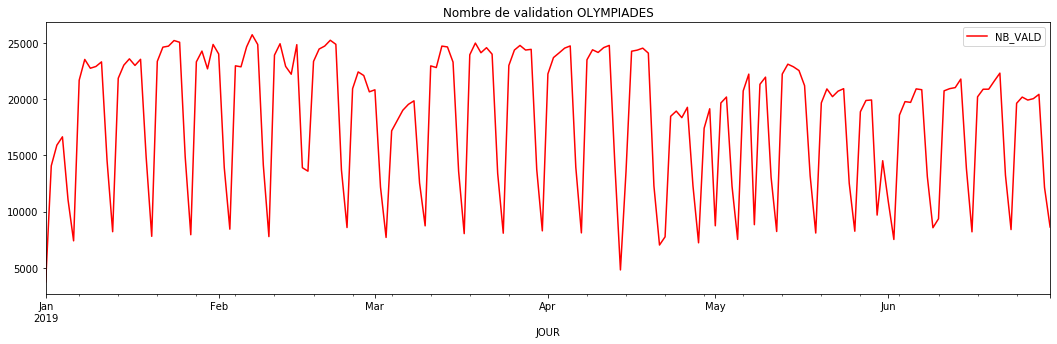

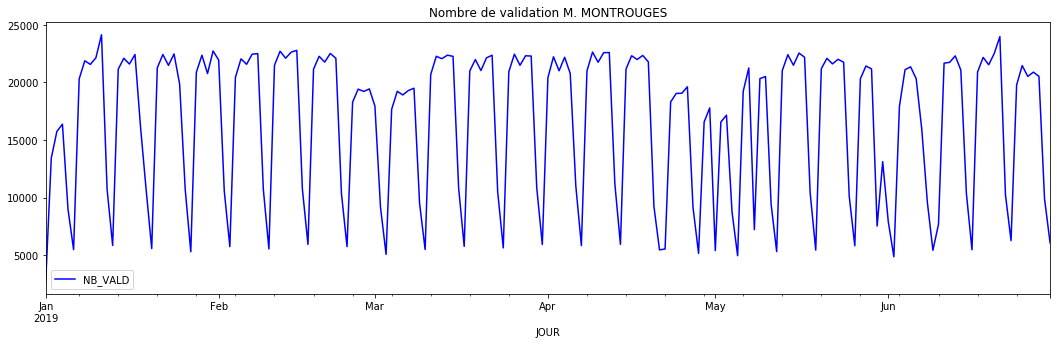

In [25]:
## Visualisation des 2 séries

ax = NB_VAl_OLYMPIADES.plot(figsize=(18,5),color ='red',title='Nombre de validation OLYMPIADES')
ax1 =NB_VAl_MONTROUGES.plot(figsize=(18,5),color ='blue',title='Nombre de validation M. MONTROUGES')

> On constate que les 2 séries présentent une forte saisonnalité hebdomadaire.

### OLYMPIADES

In [26]:
Ets_OLYMPIADES_fit = ETSModel(endog=NB_VAl_OLYMPIADES_Train.astype('float64').NB_VALD ,trend='add',dates=NB_VAl_OLYMPIADES_Train.index,seasonal='mul',seasonal_periods=7 ,damped_trend=True).fit()
## On remarque que la variance n'est pas constante donc on utilisera une composante saisonnière multiplicative 
## seasonal_periods=7 saisonnalité hebdomadaire

Ets_OLYMPIADES_test = Ets_OLYMPIADES_fit.get_prediction(start = '2019-06-10',end='2019-06-23',dynamic=False)
Ets_OLYMPIADES_forecasted_test = pd.DataFrame({'Prédictions':Ets_OLYMPIADES_test.predicted_mean})

Text(0.5, 0, 'Date')

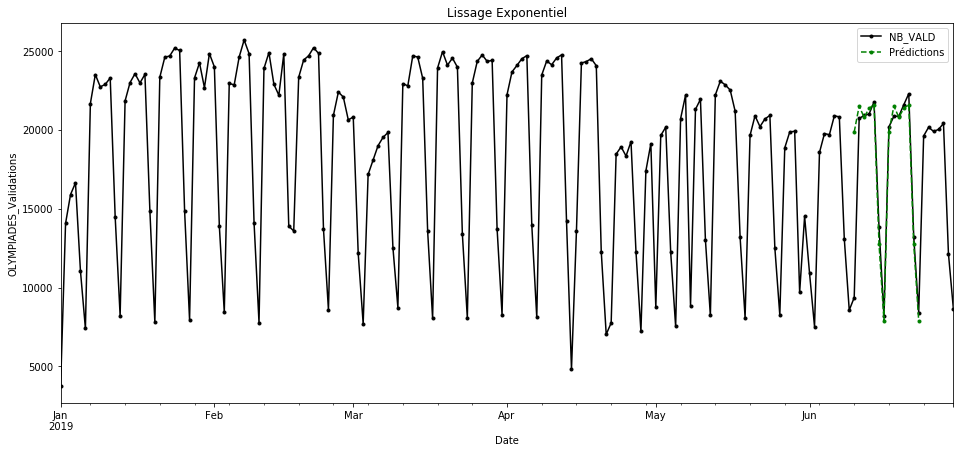

In [27]:
ax = NB_VAl_OLYMPIADES.plot(figsize=(16,7), marker='.', color='black', title="Lissage Exponentiel" )
Ets_OLYMPIADES_forecasted_test.plot(ax=ax,style = '--' ,color='green',marker='.',legend=True)

ax.set_ylabel("OLYMPIADES_Validations")
ax.set_xlabel("Date")

In [28]:
pourcentage_erreur(NB_VAl_OLYMPIADES_Test,Ets_OLYMPIADES_forecasted_test)

Le pourcentage d'erreur absolu médian est de 3.11 %


> On remarque que la première valeur sur notre ensemble test (10-06-2019) est une anomalie (On peut voir qu'il y a une sorte de cassure ). Pour éviter de mal intérpreter les performances de notre modèle sur l'ensemble test on utilisera le pourcentage d'erreur absolu médian.  
On a obtenu un pourcentage d'erreur de 3,1% , on peut le remarquer sur le graphique ( le modèle prédit très bien la majorité des valeurs de l'ensemble test )

### Prédiction du nombre de validations pour la station OLYMPIADES pour la période du 24 juin 2019 jusqu'au 30 Juin 2020

In [29]:
Ets_OLYMPIADES_fit_pr = ETSModel(endog=NB_VAl_OLYMPIADES[:-7].astype('float64').NB_VALD ,trend='add',dates=NB_VAl_OLYMPIADES[:-7].index,seasonal='mul',seasonal_periods=7 ,damped_trend=True).fit()


Ets_OLYMPIADES_pred = Ets_OLYMPIADES_fit_pr.get_prediction(start = '2019-06-24',end='2019-06-30',dynamic=True,method='simulated')
Ets_OLYMPIADES_forecasted_pred = pd.DataFrame({'Prédictions':Ets_OLYMPIADES_pred.predicted_mean,'lower':Ets_OLYMPIADES_pred.pred_int().iloc[:,0],'upper':Ets_OLYMPIADES_pred.pred_int().iloc[:,1]})

Text(0.5, 0, 'Date')

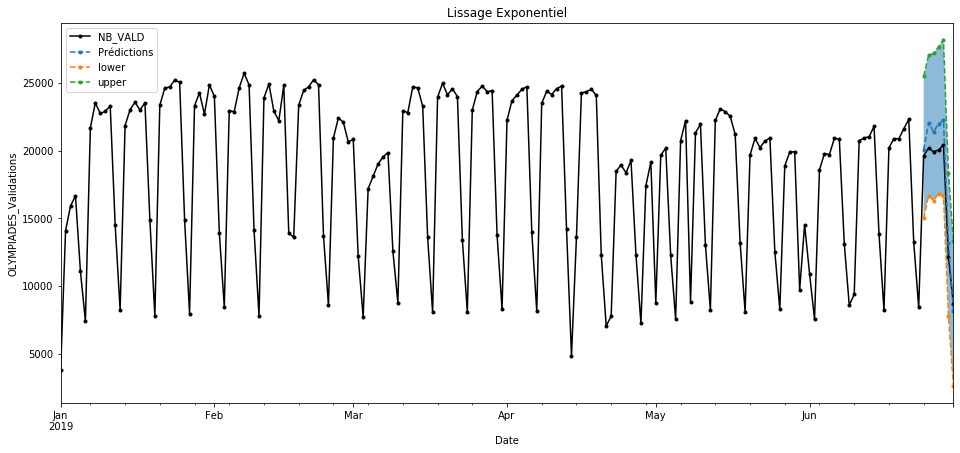

In [30]:
ax = NB_VAl_OLYMPIADES.plot(figsize=(16,7), marker='.', color='black', title="Lissage Exponentiel" )
Ets_OLYMPIADES_forecasted_pred.plot(ax=ax,style = '--' ,marker='.',legend=True)
plt.fill_between(Ets_OLYMPIADES_forecasted_pred.index ,Ets_OLYMPIADES_forecasted_pred.lower ,Ets_OLYMPIADES_forecasted_pred.upper,alpha=0.5) 
ax.set_ylabel("OLYMPIADES_Validations")
ax.set_xlabel("Date")

In [31]:
pourcentage_erreur(NB_VAl_OLYMPIADES_REEL ,Ets_OLYMPIADES_forecasted_pred.iloc[:,0])

Le pourcentage d'erreur absolu médian est de 8.55 %


In [32]:
## Les prédictions et leurs intérvalles de prédiction.
Ets_OLYMPIADES_forecasted_pred

,Prédictions,lower,upper
2019-06-24,20048.056855,14984.377829,25479.260735
2019-06-25,22050.579414,16656.846502,27034.357828
2019-06-26,21379.280388,16292.589617,27180.113631
2019-06-27,21965.682881,16818.988548,27667.840789
2019-06-28,22238.806655,16622.527243,28165.186820
2019-06-29,13187.729609,7761.913537,18373.625330
2019-06-30,8144.759321,2609.644246,13326.637704


### M. MONTROUGES

In [33]:
Ets_MONTROUGES_fit = ETSModel(endog=NB_VAl_MONTROUGES_Train.astype('float64').NB_VALD ,trend='add',dates=NB_VAl_MONTROUGES_Train.index,seasonal='add',seasonal_periods=7 ,damped_trend=True).fit()
## On remarque que la variance est presque constante donc on utilisera une composante saisonnière additive 

Ets_MONTROUGES_test = Ets_MONTROUGES_fit.get_prediction(start = '2019-06-10',end='2019-06-23',dynamic=True)
Ets_MONTROUGES_forecasted_test = pd.DataFrame({'Prédictions':Ets_MONTROUGES_test.predicted_mean})

Text(0.5, 0, 'Date')

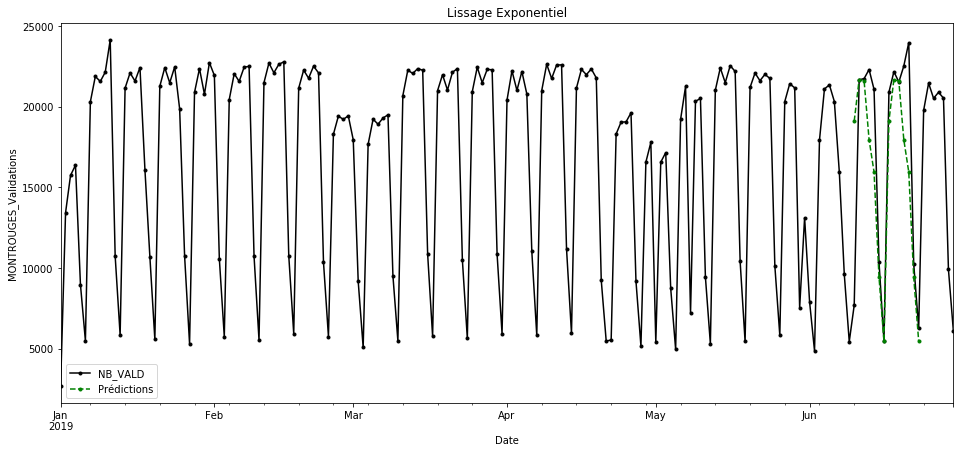

In [34]:
ax = NB_VAl_MONTROUGES.plot(figsize=(16,7), marker='.', color='black', title="Lissage Exponentiel" )
Ets_MONTROUGES_forecasted_test.plot(ax=ax,style = '--' ,color='green',marker='.',legend=True)

ax.set_ylabel("MONTROUGES_Validations")
ax.set_xlabel("Date")

### Prédiction du nombre de validations pour la station M. MONTROUGES  pour la période du 24 juin 2019 jusqu'au 30 Juin 2020

In [35]:
Ets_MONTROUGES_fit_pr = ETSModel(endog=NB_VAl_MONTROUGES[:-7].astype('float64').NB_VALD ,trend='add',dates=NB_VAl_MONTROUGES[:-7].index,seasonal='add',seasonal_periods=7 ,damped_trend=True).fit()

Ets_MONTROUGES_pred = Ets_MONTROUGES_fit_pr.get_prediction(start = '2019-06-24',end='2019-06-30',dynamic=True)
Ets_MONTROUGES_forecasted_pred = pd.DataFrame({'Prédictions':Ets_MONTROUGES_pred.predicted_mean,'lower':Ets_MONTROUGES_pred.pred_int().iloc[:,0],'upper':Ets_MONTROUGES_pred.pred_int().iloc[:,1]})

Text(0.5, 0, 'Date')

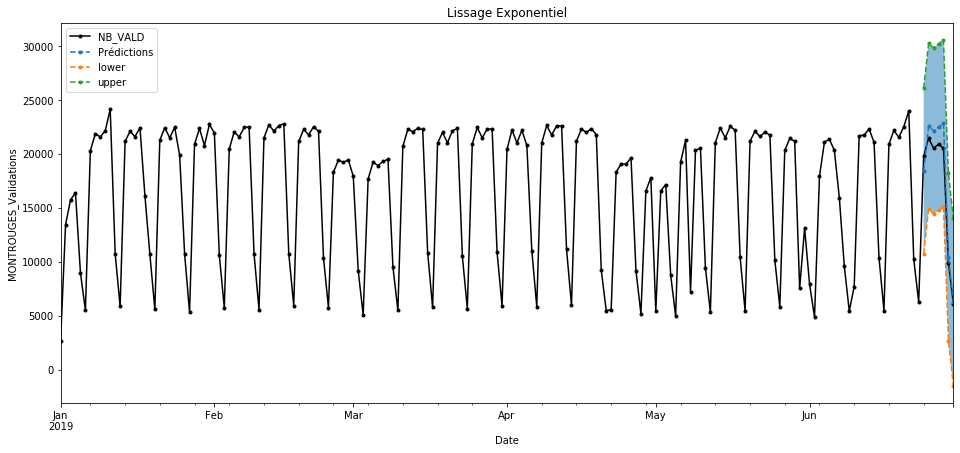

In [36]:
ax = NB_VAl_MONTROUGES.plot(figsize=(16,7), marker='.', color='black', title="Lissage Exponentiel" )
Ets_MONTROUGES_forecasted_pred.plot(ax=ax,style = '--' ,marker='.',legend=True)
plt.fill_between(Ets_MONTROUGES_forecasted_pred.index ,Ets_MONTROUGES_forecasted_pred.lower ,Ets_MONTROUGES_forecasted_pred.upper,alpha=0.5) 
ax.set_ylabel("MONTROUGES_Validations")
ax.set_xlabel("Date")

In [37]:
pourcentage_erreur(NB_VAl_MONTROUGES_REEL ,Ets_MONTROUGES_forecasted_pred.iloc[:,0])

Le pourcentage d'erreur absolu médian est de 6.85 %


In [38]:
## Les prédictions et leurs intérvalles de prédiction.

Ets_MONTROUGES_forecasted_pred

,Prédictions,lower,upper
2019-06-24,18426.252333,10741.290482,26111.214183
2019-06-25,22548.946289,14848.785357,30249.107221
2019-06-26,22143.088382,14427.755757,29858.421008
2019-06-27,22493.022312,14762.545430,30223.499194
2019-06-28,22827.547297,15081.953625,30573.140969
2019-06-29,10425.043508,2664.360527,18185.726488
2019-06-30,6254.099422,-1521.645385,14029.844228
